In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("oc20_data_mapping.pkl", "rb") as input_file:
    mappings = pickle.load(input_file)

In [3]:
df_val_id = pd.read_csv("val_id_30k_anomalies.csv", index_col=0) 
df_val_id

,sid,fid,ref_energies,surface_anomalies,adsorbate_dissociated_anomalies,adsorbate_desorbed_anomalies,cat_class,bulk_symbols,ads_symbols,val_id_goc,val_id_eqv2,val_id_escn,goc_forces_maes,escn_forces_maes,eqv2_forces_maes
0,random2163697,34,-0.866727,0,0,1,2,SnPbSe2,*CHOCH2OH,-1.0750,-1.0240,-1.0110,0.015447,0.010043,0.009077
1,random2099289,25,-1.864362,0,0,0,0,Ti3Ga,*OHCH3,-1.8640,-1.8970,-1.8930,0.012776,0.012838,0.010518
2,random1899087,116,-1.309746,0,0,0,1,Ge8Mo4,*OCH2CHOH,-1.3520,-1.3640,-1.3200,0.039622,0.029826,0.030165
3,random2242031,38,-1.562169,0,0,0,1,V10Si6,*ONN(CH3)2,-1.5500,-1.5760,-1.5540,0.012542,0.013048,0.009500
4,random452544,739,-3.829937,0,1,0,2,N12Al4Ca12,*OH2,-3.8400,-4.5200,-4.1700,0.006008,0.007014,0.006463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,random1405445,181,-0.722562,0,0,0,2,Na4Se4Pt2,*CH*CH,-0.6655,-0.8413,-0.6436,0.024341,0.015965,0.011855
29996,random1159418,50,-3.723823,0,0,0,0,Al8Hf12,CH2*CO,-3.8950,-3.7520,-3.7540,0.021861,0.015483,0.013978
29997,random1906766,221,4.258890,0,0,0,1,Sb8Ir4,*NO2,4.2660,4.2600,4.2660,0.005737,0.005343,0.005286
29998,random1850524,307,-1.782513,0,0,0,0,AlScCu2,*CCHO,-1.7850,-1.7640,-1.7540,0.007241,0.005780,0.006117


In [4]:
for df in [df_val_id]:
    material_classes = []
    surfaces = []
    adsorbates = []
    for i in tqdm(df["sid"].values):
        material_classes.append(mappings[i]["class"])
        surfaces.append(mappings[i]["bulk_symbols"])
        adsorbates.append(mappings[i]["ads_symbols"])
    material_classes = np.array(material_classes)
    # add system information to the dataframe
    df["cat_class"] = material_classes
    df["bulk_symbols"] = surfaces
    df["ads_symbols"] = adsorbates

100%|██████████| 30000/30000 [00:00<00:00, 440548.84it/s]


In [5]:
surface_anomaly_dict = {}
ads_anomalies_dict = {}
for material in [0,1,2,3]:
    surface_anomaly_dict[material] = len(df_val_id.query(f"cat_class=={material}&surface_anomalies==1"))/len(df_val_id.query(f"cat_class=={material}"))
    ads_anomalies_dict[material] = len(df_val_id.query(f"cat_class=={material}&(adsorbate_dissociated_anomalies==1 or adsorbate_desorbed_anomalies==1)"))/len(df_val_id.query(f"cat_class=={material}"))

# the ML errors across the material classes
val_id_dict = {}
for material in [0,1,2,3]:
    val_id_dict[material] = np.mean(np.abs(df_val_id.query(f"cat_class=={material}")["val_id_goc"] \
                                             - df_val_id.query(f"cat_class=={material}")["ref_energies"]))

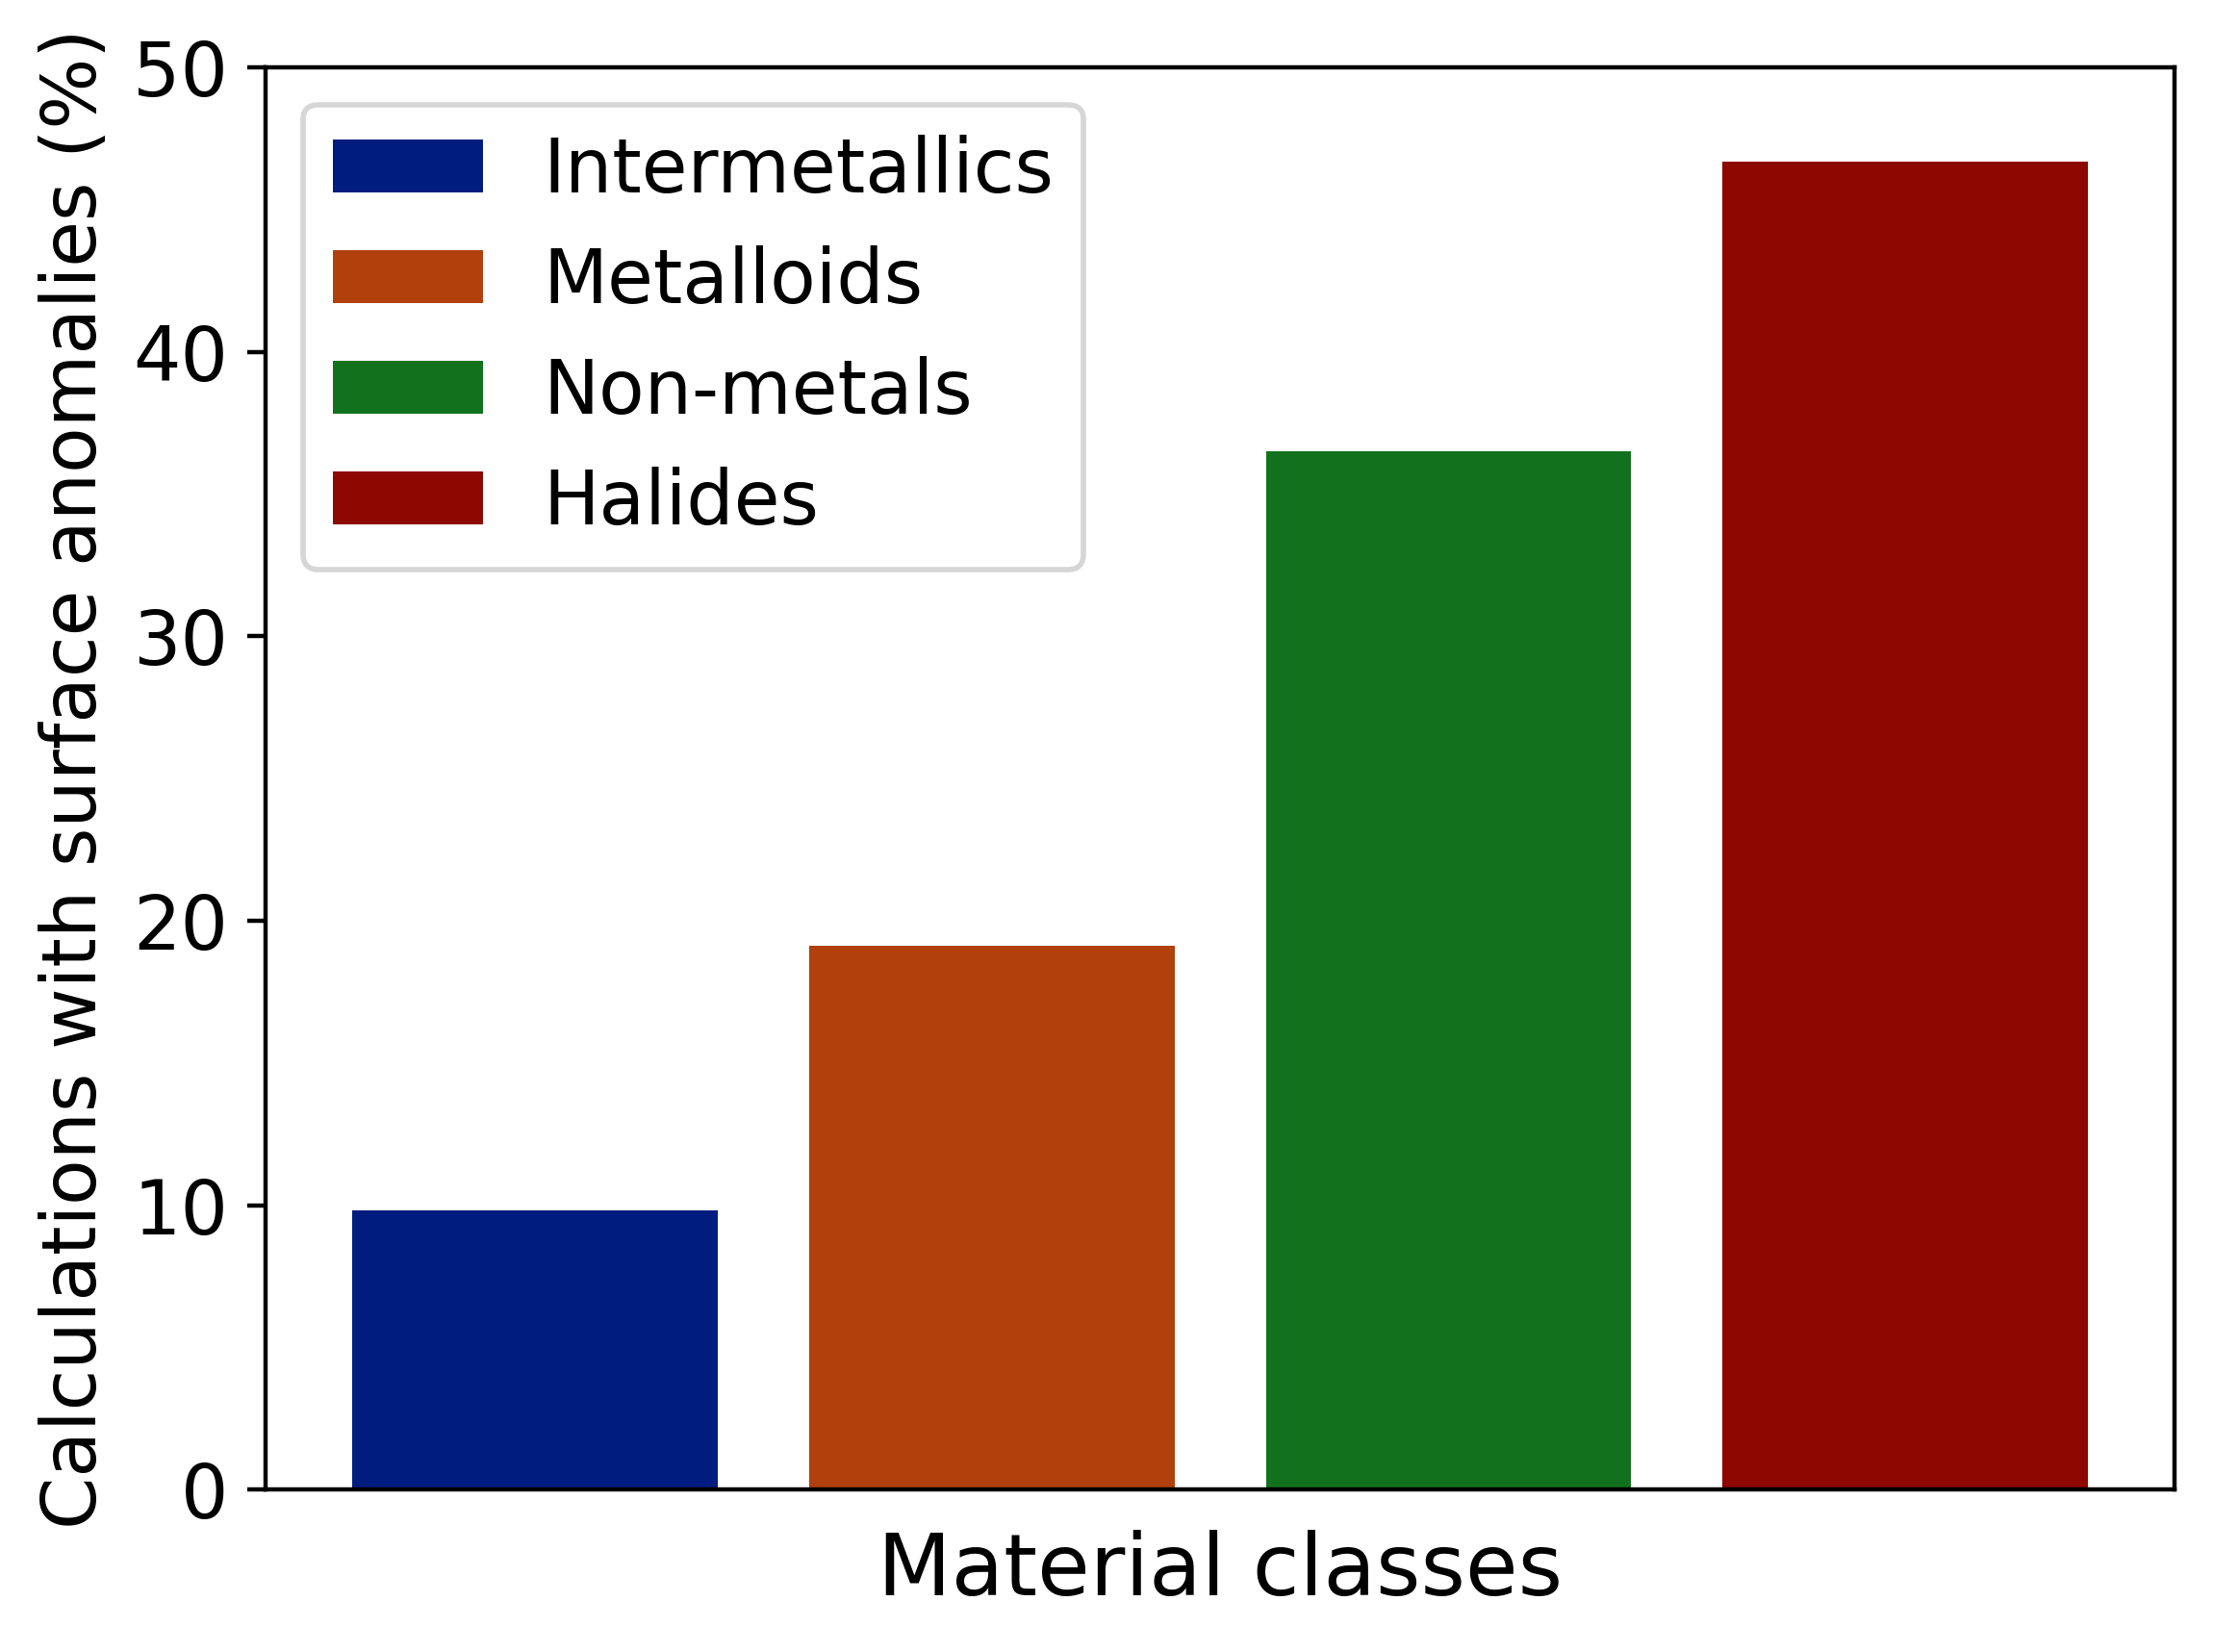

In [6]:
plt.figure(dpi=400)

# Define colors for different categories
colors = {'Intermetallics': '#001c7f', 'Metalloids': '#b1400d', 'Non-metals': '#12711c', 'Halides': '#8c0800'}

keys = ['Intermetallics','Metalloids','Non-metals','Halides']
# Plot the bar chart with specified colors
plt.bar(list(surface_anomaly_dict.keys()), np.array(list(surface_anomaly_dict.values()))*100, color=[colors[category] for category in keys], label=keys)

plt.ylabel("Calculations with surface anomalies (%)", fontsize=14)
plt.xlabel("Material classes", fontsize=16)
plt.xticks([])
plt.yticks(fontsize=14)
plt.ylim(0,50)
plt.legend(fontsize=14)
plt.show()

In [7]:
original_dict = {}
no_surface_anomaly_dict = {}
no_anomaly_dict = {}
for material in [0,1,2,3]:
    original_dict[material] = np.mean(np.abs(df_val_id.query(f"cat_class=={material}")["val_id_goc"] \
                                             -df_val_id.query(f"cat_class=={material}")["ref_energies"]))
    no_surface_anomaly_dict[material] = np.mean(np.abs(df_val_id.query(f"cat_class=={material}&surface_anomalies!=1")["val_id_goc"] \
        -df_val_id.query(f"cat_class=={material}&surface_anomalies!=1")["ref_energies"]))
    no_anomaly_dict[material] = np.mean(np.abs(df_val_id.query(f"cat_class=={material}&surface_anomalies!=1&adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["val_id_goc"] \
        -df_val_id.query(f"cat_class=={material}&surface_anomalies!=1&adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["ref_energies"]))

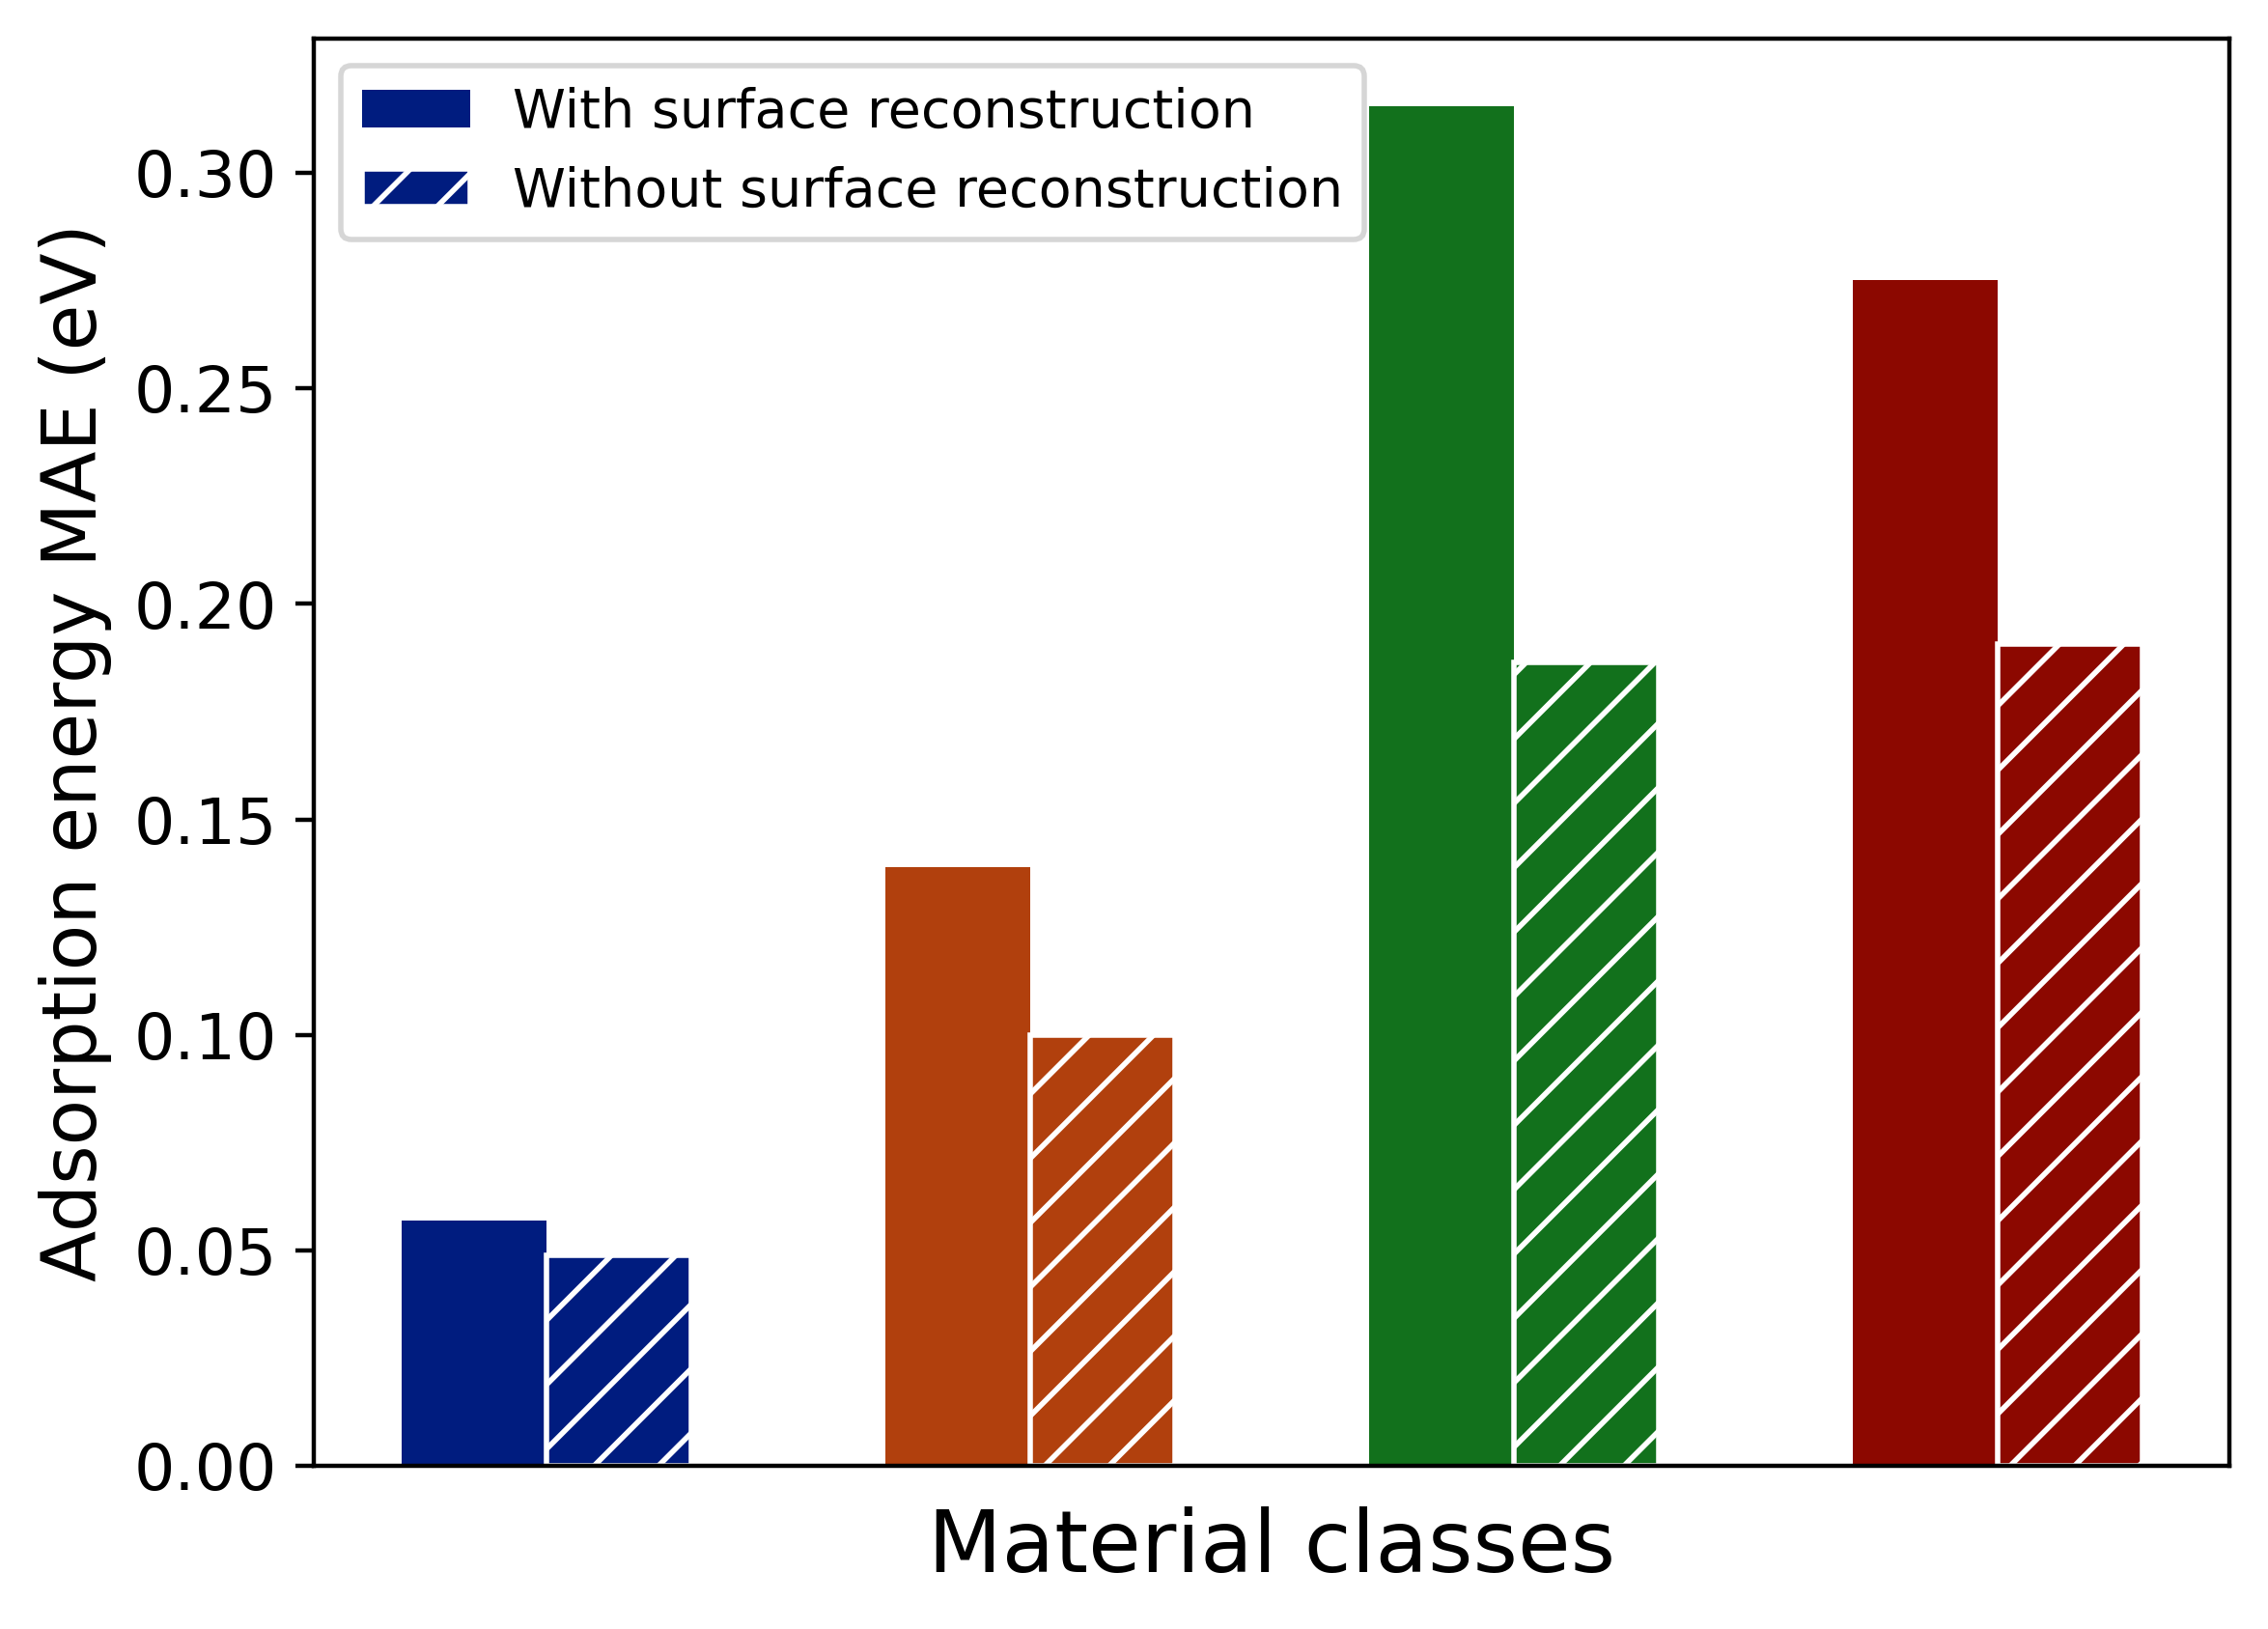

In [8]:
# Extract labels and mean values
materials = ["intermetallics", "metalloids", "nonmetals", "halides"]
labels = list(original_dict.keys())
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(dpi=400)

# Plotting the bars
ax.bar(x - width/2, list(original_dict.values()), width, label='With surface reconstruction', color = colors.values())
ax.bar(x+ width/2, list(no_surface_anomaly_dict.values()), width, label='Without surface reconstruction', 
       color = colors.values(),edgecolor='white',hatch='//' )

# Add legend
ax.legend()
# Add labels and title
ax.set_ylabel('Adsorption energy MAE (eV)',fontsize=14)
ax.set_xticks(labels)
ax.set_xticks(labels, materials)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Material classes", fontsize=16)
plt.xticks([]);